# **Data Pipeline Project using Telegram and AWS**

Por [Luiz Krawiec](https://www.linkedin.com/in/luizkrawiec/)

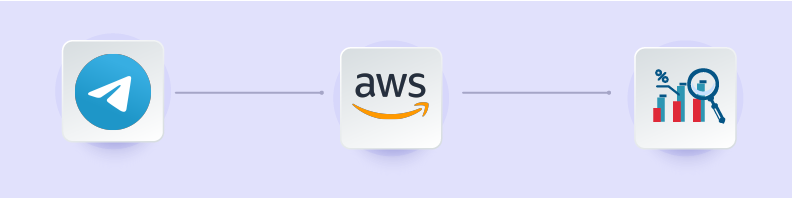

# **1. Context**

### **1.1 What is a chatbot after all?**



A chatbot is a type of software that interacts with users through automated conversations on messaging platforms. A common example of application for chatbots is customer service, where, in many cases, they assist customers in problem-solving or answering frequently asked questions before the intervention of a human attendant.

### **1.2. Telegram**


Telegram is a freeware (distributed for free) instant messaging platform, largely open-source. It is widely used by developers due to its pioneering position in implementing chatbot creation functionality, which enables the automation of a variety of tasks.

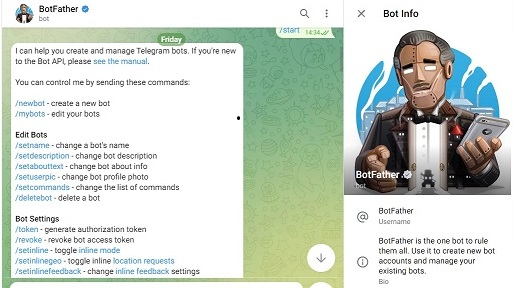

### **1.3. The Architecture**

An analytical task of interest involves conducting an exploratory analysis of the data received by a chatbot to answer questions such as:

1. What is the time when users interact with the bot the most?
2. What is the most common problem or question?
3. Is the bot effectively solving problems or clarifying doubts?

Therefore, we propose the creation of a data pipeline that performs the ingestion, processing, storage, and exposure of messages from a group on Telegram, allowing data professionals to conduct analyses. The suggested architecture is divided into two parts: a transactional one on Telegram, where the data is generated, and an analytical one on Amazon Web Services (AWS), where the data is analyzed.

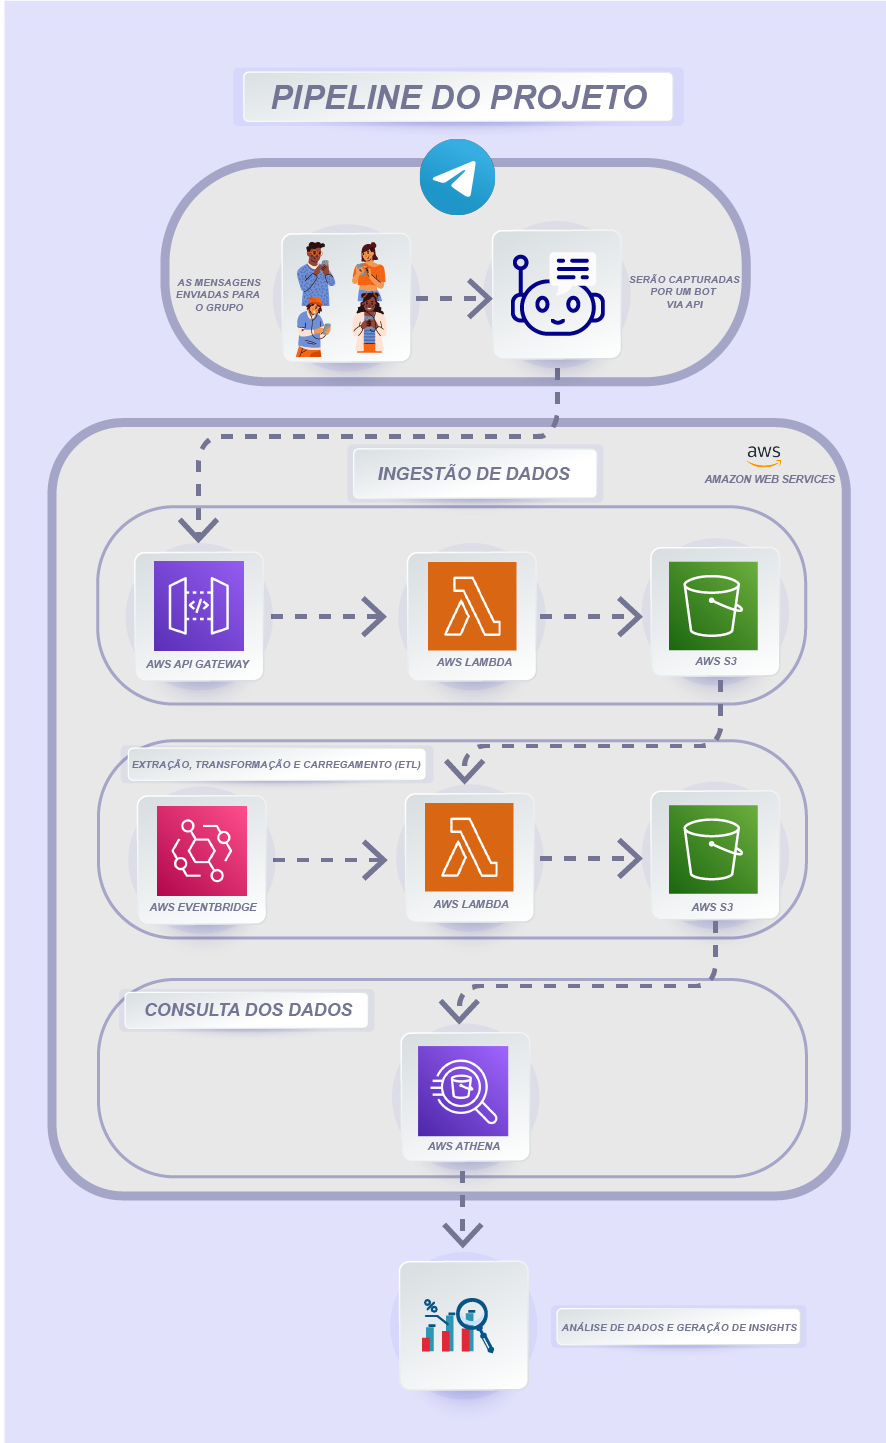



 - **Telegram**



 > The Telegram acts as the source of transactional data. Messages sent by users in a group are captured by a bot and redirected through the backend application's webhook to an endpoint (a web address that accepts HTTP requests) exposed by the AWS API Gateway. The messages are transported in the body or payload of the request.



 - **AWS | Ingestion**

>An HTTP request, containing the message content in its payload, is received by the AWS API Gateway, which then forwards this information to AWS Lambda, acting as its trigger. AWS Lambda, in turn, receives the request payload in the "event" parameter, records the content in a file in JSON format (maintaining the original payload format), and stores it in AWS S3, organized by daily partitions.

- **AWS | ETL**

> Every day, the AWS EventBridge triggers AWS Lambda, which processes all messages from the previous day (with a one-day delay, or D-1). During this process, the semi-structured data, commonly found in JSON files, is denormalized. The processed content is then recorded in a file in Apache Parquet format and stored in AWS S3, organized into daily partitions.

- AWS | Presentation

> Finally, a table in AWS Athena is linked to the bucket in AWS S3 containing the processed data: denormalized, partitioned, and columnar-oriented. This enables data professionals to run analytical queries (aggregations, sorting, etc.) on the table, using SQL to extract valuable insights.

# **2. Data Ingestion**

#### **2.1 What is an API?**

For the project, messages are collected by a bot and can be retrieved through an API.

An API (Application Programming Interface) is a set of rules and definitions that allows different software to communicate with each other. This interface enables an application to access functionalities or data from another, acting as a bridge for the exchange of information. APIs are essential for system and service integration, allowing developers to connect different software components efficiently and interoperably.

The only required information is the access token granted by BotFather during the bot creation.

Reference:

*Oracle. (2022). What is an API? Understanding the Basics. https://www.oracle.com/cloud/what-is/api/*

#### **2.2 Ingestion**

The ingestion phase is responsible, as the name suggests, for incorporating transactional data into analytical environments. In general terms, the ingested data is kept in the format as close to the original as possible, meaning without any alteration in its content or structure (schema). For example, data from a web API following the REST (Representational State Transfer) format is received and consequently stored in JSON format.

Preserving the data in its original format offers several advantages, especially reprocessing capability. This persistence can be achieved in two ways:

- **Batch**: Data blocks are incorporated at a well-defined frequency, usually at intervals of hours or days.
- **Streaming**: Data is incorporated as it is produced and made available.

In the context of this project, messages captured by the Telegram bot can be incorporated through the Telegram bot's web API, providing the data in JSON format. Since Telegram retains messages for only 24 hours on its servers, streaming ingestion is more appropriate. To enable this type of ingestion, a webhook will be used to automatically redirect the messages to another web API.

Therefore, an AWS service is needed to provide a web API to receive the redirected data, with AWS API Gateway chosen for this purpose. Among its various functionalities, AWS API Gateway allows forwarding of received data to other AWS services. Thus, we will connect it to AWS Lambda, which in turn will store the data in its original format (JSON) in an AWS S3 bucket.

Systems that respond to events are commonly referred to as event-driven systems.



#### **2.3 Steps Required**

1. Establish a bucket on AWS S3;
1. Develop a function on AWS Lambda;
1. Configure a web API on AWS API Gateway;
1. Adjust the webhook of the Telegram bot API.

#### **2.4 S3 on AWS**


In the ingestion phase, AWS S3 plays the role of passively storing the messages captured by the Telegram bot in their original format: JSON. To achieve this, it is sufficient to create a "bucket". By default, we will append the suffix "-raw" to its name (following this convention for all services in this layer).

> A quick note: a data lake is the term given to a repository of large volumes of data. It is structured into zones that store replicas of the data at various processing levels. Although the nomenclature of the zones may vary, the most common ones include: raw and enriched, or bronze, silver, and gold.

### **2.5 AWS Lambda**


In the ingestion phase, AWS Lambda plays an active role in persisting the messages captured by the Telegram bot in an AWS S3 bucket. To achieve this, we will create a function that operates as follows:

1. Receives the message in the "event" parameter;
2. Checks if the message originates from the correct Telegram group;
3. Persists the message in JSON format in the AWS S3 bucket;
4. Returns a success message (HTTP return code equal to 200) to the Telegram bot API.

Code used in AWS Lambda

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")


To ensure proper functioning of the function, some configurations need to be adjusted.

**Environment Variables:**
- Note that the code requires the configuration of two environment variables: AWS_S3_BUCKET with the name of the AWS S3 bucket and TELEGRAM_CHAT_ID with the Telegram group chat ID. To include environment variables in an AWS Lambda function, simply access Settings -> Environment Variables in the function's console.

*Note: Environment variables represent an excellent way to store sensitive information.*


**Permission:**
- Lastly, it is necessary to grant write permission to the AWS Lambda function on the AWS S3 bucket in AWS IAM.

### **2.6 AWS API Gateway**

In the ingestion step, I am using AWS API Gateway to receive messages captured by my Telegram bot, sent via webhook, and trigger a function in my AWS Lambda, passing the message content in its "event" parameter. To do this, I am following the steps below when creating an API and configuring it as a trigger for my Lambda function:

1. Accessed the service and chose: Create API -> REST API;
2. Entered a name, preferably one ending with the suffix "-api";
3. Selected: Actions -> Create Method -> POST;

In the configuration screen:
- Selected the integration type as Lambda Function;
Enabled the use of Lambda proxy integration;
Looked up the name of my function in AWS Lambda.
I could test the integration with AWS Lambda using the service's testing tool. Finally, I proceeded with deploying the API to obtain the web address.



### **2.7 In Telegram**

I will configure the webhook to redirect messages to the URL of the AWS API Gateway.

**setWebhook:**
- The setWebhook method configures the redirection of messages captured by my bot to the specified web address in the "url" parameter.

*Note: The getUpdates and setWebhook methods are mutually exclusive, meaning while the webhook is active, the getUpdates method will not work. To disable the webhook, simply use the deleteWebhook method.*

**Códigos Usados**

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

 - **getWebhookInfo**

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

# **3\. ETL - Extraction, Transformation and Load**

**3.1 Extraction, Transformation and Load**

The Extraction, Transformation, and Loading (ETL) phase is a comprehensive step responsible for handling data from transactional systems, i.e., data already stored in the raw layers of analytical systems. The procedures performed in this phase vary considerably depending on the company's area, volume, variety, and velocity of consumed data, among other factors. In general terms, however, the ingested raw data undergoes a continuous process of "data wrangling," where it is cleaned, deduplicated, etc., before being stored using partitioning, columnar orientation, and compression techniques. At the end of this process, the processed data is ready to be analyzed by data professionals.

In the context of this project, messages from a single day, already stored in the raw layer, will be consolidated into a single file, column-oriented, and compressed, before being persisted in the enriched layer. Additionally, during this stage, the data will also undergo "data wrangling" processes.

To achieve these objectives, we will use an AWS Lambda function as the processing engine and an AWS S3 bucket as the enriched layer to store the processed data. To ensure the recurrence of this process, we will set up a rule in AWS EventBridge to trigger the function daily.

**3.2 AWS S3**


In the ETL phase, AWS S3 plays the role of passively storing the processed messages of a day in a single Parquet file. To achieve this, it is sufficient to create a "bucket". By default, we will append the suffix "-enriched" to its name (maintaining this convention for all services in this layer).

- *Reminder: a data lake is the term given to a repository of large volumes of data. It is structured into zones that store replicas of the data at different processing stages. The nomenclature of the zones may vary, however, the most common ones include: raw and enriched, or bronze, silver, and gold.*

**3.3 AWS Lambda**

In the ETL phase, AWS S3 plays the role of passively storing the processed messages of a day in a single Parquet file. To achieve this, it is sufficient to create a "bucket". By default, we will append the suffix "-enriched" to its name (maintaining this convention for all services in this layer).

- *Reminder: a data lake is the term given to a repository of large volumes of data. It is structured into zones that store replicas of the data at different processing stages. The nomenclature of the zones may vary, however, the most common ones include: raw and enriched, or bronze, silver, and gold.*

The code used was as follows:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

And to perform the wrangling, I used the following code.

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

**Environment Variables Settings**

It's important to note that the code requires configuration of two environment variables: `AWS_S3_BUCKET` and `AWS_S3_ENRICHED`, which correspond to the names of the AWS S3 buckets for the raw and enriched layers, respectively. To add environment variables to an AWS Lambda function, simply access Settings -> Environment Variables in the function's console.

**Permissions**
It is necessary to grant write permission to the AWS S3 buckets for the AWS Lambda function in AWS IAM.

**Resources**
The default timeout for AWS Lambda functions is 3 seconds. In the case of this function, we will increase the time to 5 minutes, especially to handle file input/output operations on AWS S3.

**3.4 AWS Event Bridge**


In the ETL phase, AWS EventBridge plays a crucial role in triggering the ETL function on AWS Lambda daily. This operational dynamic is essential, as EventBridge acts as a reliable task scheduler, ensuring the regular and automated execution of the extraction, transformation, and loading (ETL) process. Thus, this integration between EventBridge and Lambda establishes an efficient and scheduled operation, ensuring consistency and recurrence in data manipulation over time.

# **4\. Data Presentation**

### **4.1. AWS Athena**

In the presentation phase, AWS Athena plays a fundamental role in providing data through an SQL interface to users of the analytical system. To create this interface, it is simply necessary to establish an external table based on the data stored in the most refined layer of the architecture, the enriched layer. AWS Athena allows users to perform SQL queries directly on the data stored in Parquet format, providing an agile and intuitive experience for information analysis. This integration facilitates the extraction of valuable insights by data professionals, contributing to informed and effective decision-making.

**Table Creation**

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-m42-enriquecido>/'
```

The querys

```sql
SELECT * FROM `telegram` LIMIT 10;
```

The Athena service page displays the query result as follows:

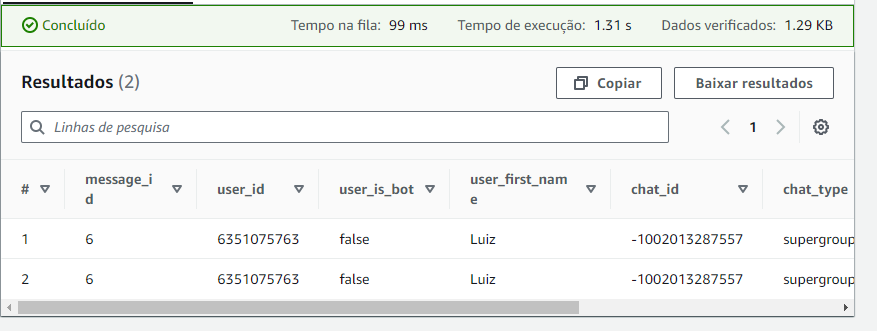

### **4.2. Analytics**

With the available data, users have the ability to perform various analytical queries. Below are some examples:

1. Daily message count.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

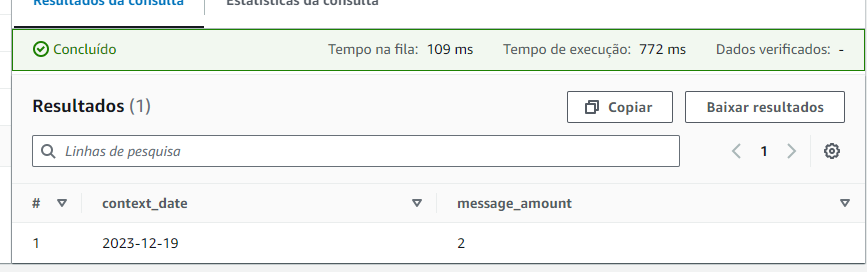

- Number of messages per user per day.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

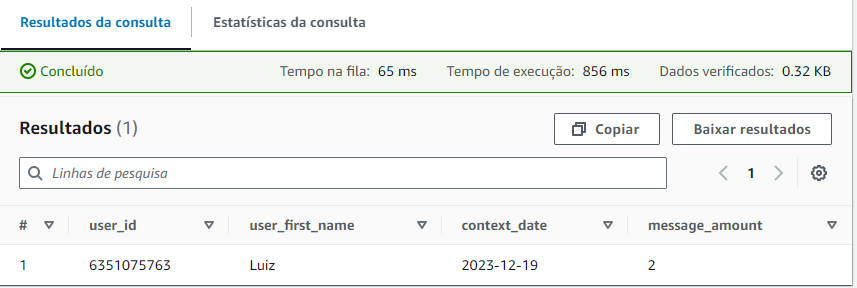

- Average message size per user per day.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

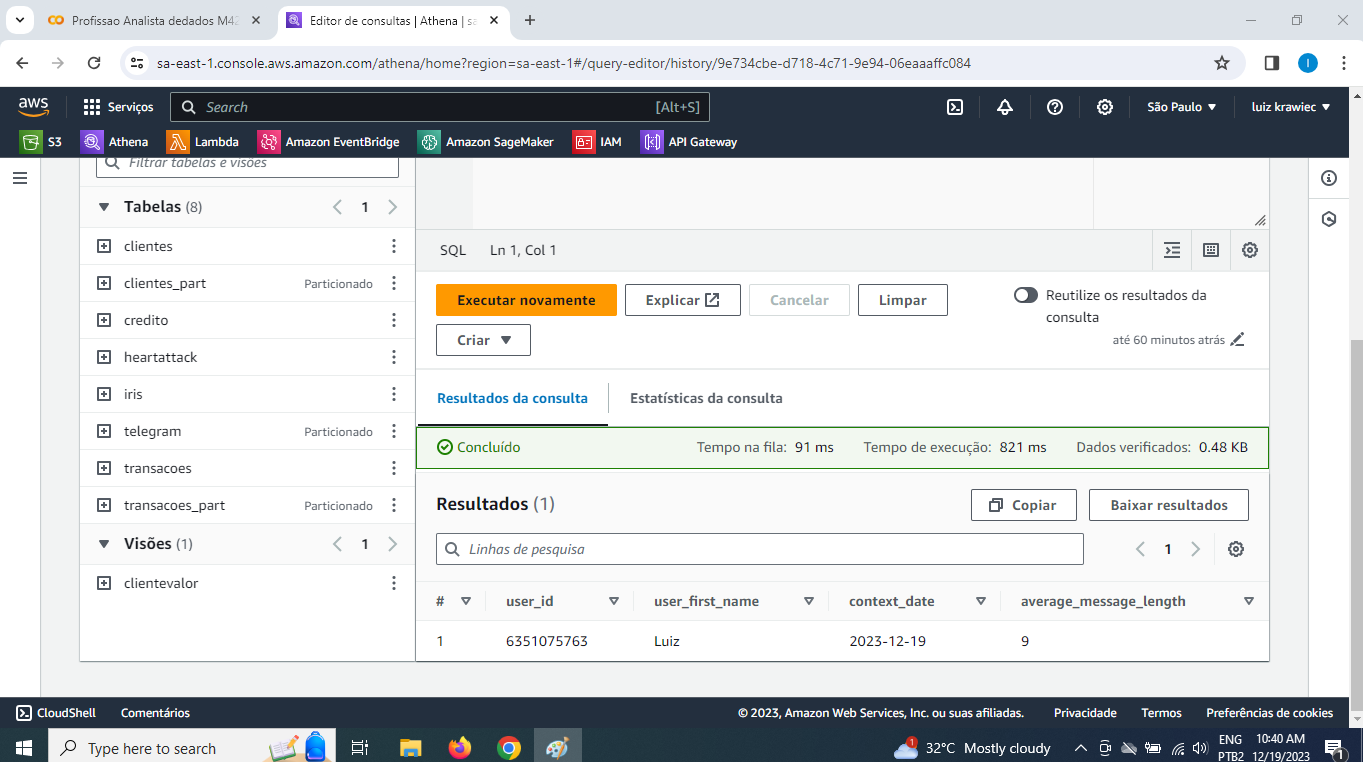

- Number of messages per hour per day of the week per week number.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

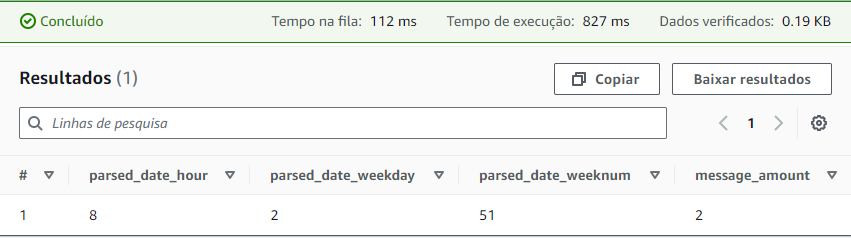

# **5\. Conclusion**

The integration of chatbots into messaging applications, such as Telegram, combined with the powerful cloud infrastructure provided by AWS, including notable services like S3, AWS Lambda, and AWS Gateway, represents a significant milestone in improving user experience and operational optimization. This convergence of technologies opens new perspectives for data analysis, promoting substantial advancements in business strategies.

By integrating chatbots into popular messaging platforms like Telegram, companies can provide instant and personalized interactions, enhancing communication with users. AWS, in turn, plays a crucial role in this scenario by providing robust and scalable infrastructure. Amazon S3 offers secure and reliable storage for data, while AWS Lambda enables code execution without the need to manage servers, providing operational efficiency and resource savings.

AWS Gateway, as the entry point for APIs, simplifies and streamlines communication between different services, ensuring smooth integration between the chatbot and other components of the ecosystem. This technological cohesion not only enhances operational efficiency but also provides a fertile ground for large-scale data analysis.

A análise de dados torna-se mais acessível e eficiente, com a capacidade de extrair insights valiosos das interações dos usuários com o chatbot. Informações cruciais são processadas e armazenadas de forma segura no S3, enquanto o AWS Lambda permite a execução de análises em tempo real, possibilitando uma tomada de decisões mais informada e ágil.

Em conclusão, a integração de chatbots em aplicativos de mensagens, aliada à infraestrutura em nuvem oferecida pela AWS, cria uma sinergia poderosa. Essa abordagem não apenas eleva a experiência do usuário, mas também impulsiona a eficiência operacional e fornece uma base sólida para análises de dados avançadas, capacitando as empresas a prosperarem na era da transformação digital.